# Brain Tumor MRI CNN Training Notebook




### Imports, Hyperparameters, and Data Paths




In [86]:
#Imports 
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
import torch.nn as nn
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
import itertools


# Hyperparameters
DATA_DIR = 'data/kaggle'
BATCH_SIZE = 32
LR = 0.005
REG = 1e-3
EPOCHS = 20
STEPS = 10
WARMUP = 0
MOMENTUM = 0.9
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Dataset Class

In [62]:
SPLIT_MAP = {'train' : 'Training', 'test' : 'Testing'}

class BrainTumorDataset(Dataset):
  CLASSES = ['notumor', 'meningioma', 'glioma', 'pituitary']
  
  def __init__(self, root_dir, split='train', transform = None):
    self.transform = transform
    split_directory = os.path.join(root_dir, SPLIT_MAP.get(split, split))
    self.img, self.lbl = [], []
    for index, cls in enumerate(self.CLASSES):
       cls_dir = os.path.join(split_directory, cls)
       for first_name in os.listdir(cls_dir):
          if first_name.lower().endswith(('.png','.jpg')):
            self.img.append(os.path.join(cls_dir, first_name))
            self.lbl.append(index)

  def __len__(self): return len(self.img)
  def __getitem__(self, i):
    image = Image.open(self.img[i]).convert('L')
    if self.transform: 
      image = self.transform(image)
    return image, self.lbl[i]

### Data Augmentations

- Random flips
- Random rotations
- Contrast and brightness differences
- Grayscale
- Uniform 224x224 size

In [63]:
GRAY_MEAN, GRAY_STD = [0.5], [0.5]

get_train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(GRAY_MEAN, GRAY_STD),
])

get_val_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(GRAY_MEAN, GRAY_STD),
])


### CNN Baseline Model

In [64]:
class CNN(nn.Module):
  def __init__(self, num_classes=4):
    super().__init__()
    self.features = nn.Sequential(
      nn.Conv2d(1, 32, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(2),

      nn.Conv2d(32, 64, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(2),

      nn.Conv2d(64, 128, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(2),
    )

    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Dropout(0.5),
      nn.Linear(128 * 28 * 28, 256),
      nn.ReLU(inplace=True),
      nn.Dropout(0.5),
      nn.Linear(256, num_classes),
    )

  def forward(self, x):
    x = self.features(x)
    x = self.classifier(x)
    return x


### Training & Validation Functions


In [65]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train(); sum_of_loss = sum_of_accuracy = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward(); optimizer.step()
        sum_of_loss += loss.item()*images.size(0)
        sum_of_accuracy  += (output.argmax(1)==labels).sum().item()
        x = len(loader.dataset)
    return sum_of_loss/x, sum_of_accuracy/x

def validate(model, loader, criterion, device):
    model.eval(); sum_of_loss = sum_of_accuracy = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            sum_of_loss += criterion(output,labels).item()*images.size(0)
            sum_of_accuracy  += (output.argmax(1)==labels).sum().item()
            x = len(loader.dataset)

    return sum_of_loss/x, sum_of_accuracy/x

### Training Loop

In [67]:
train_loader = DataLoader(
    BrainTumorDataset(DATA_DIR,'train',get_train_transforms),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
validation_loader   = DataLoader(
    BrainTumorDataset(DATA_DIR,'test', get_val_transforms),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

cnn_model = CNN().to(DEVICE)
criterion = CrossEntropyLoss()
optimizer = SGD(cnn_model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=REG)

train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(1, EPOCHS+1):
        train_loss, train_acc = train_one_epoch(cnn_model, train_loader, criterion, optimizer, DEVICE)
        val_loss, val_acc = validate(cnn_model, validation_loader, criterion, DEVICE)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(
        f"Epoch {epoch:02d}/{EPOCHS}  "
        f"Train loss={train_loss:.4f}, acc={train_acc:.4f}  "
        f"Val   loss={val_loss:.4f}, acc={val_acc:.4f}",
        flush=True
        )



Epoch 01/20  Train loss=0.8915, acc=0.6257  Val   loss=0.6777, acc=0.7132
Epoch 02/20  Train loss=0.6322, acc=0.7532  Val   loss=0.5847, acc=0.7551
Epoch 03/20  Train loss=0.5451, acc=0.7885  Val   loss=0.5870, acc=0.7407
Epoch 04/20  Train loss=0.4662, acc=0.8220  Val   loss=0.4414, acc=0.8078
Epoch 05/20  Train loss=0.3952, acc=0.8473  Val   loss=0.3746, acc=0.8452
Epoch 06/20  Train loss=0.3761, acc=0.8531  Val   loss=0.4046, acc=0.8261
Epoch 07/20  Train loss=0.3271, acc=0.8750  Val   loss=0.3160, acc=0.8658
Epoch 08/20  Train loss=0.3074, acc=0.8818  Val   loss=0.3056, acc=0.8688
Epoch 09/20  Train loss=0.2777, acc=0.8958  Val   loss=0.2523, acc=0.9001
Epoch 10/20  Train loss=0.2625, acc=0.8995  Val   loss=0.2341, acc=0.9069
Epoch 11/20  Train loss=0.2278, acc=0.9158  Val   loss=0.2314, acc=0.9062
Epoch 12/20  Train loss=0.2224, acc=0.9174  Val   loss=0.2437, acc=0.8993
Epoch 13/20  Train loss=0.2028, acc=0.9266  Val   loss=0.1618, acc=0.9405
Epoch 14/20  Train loss=0.1849, acc=0.

### Accuracy & Loss Curves

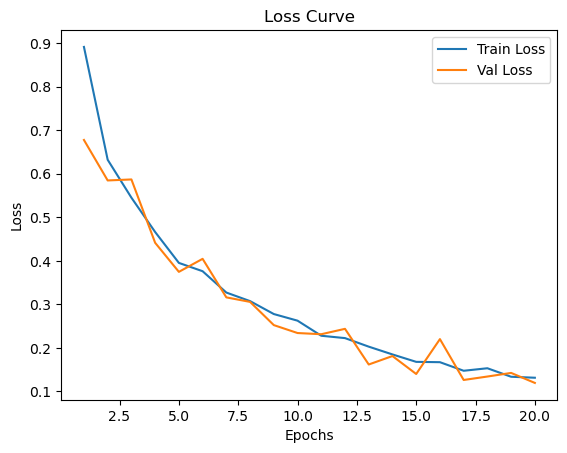

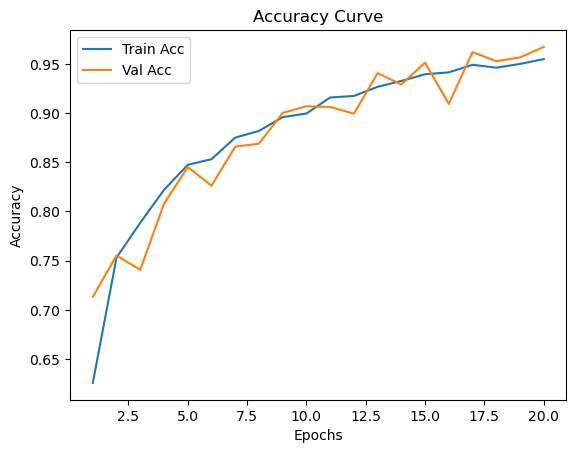

In [75]:
epochs = range(1, len(train_losses)+1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.legend(); plt.title('Loss Curve'); plt.show()

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, train_accs, label='Train Acc')
plt.plot(epochs, val_accs, label='Val Acc')
plt.legend(); plt.title('Accuracy Curve'); plt.show()




### Accuracy Scores

In [83]:
cnn_model.eval()
y_pred, y_true = [], []

with torch.no_grad():
  for images, labels in validation_loader:
    images = images.to(DEVICE)
    outputs = cnn_model(images)
    preds = outputs.argmax(dim=1).cpu().numpy()
    y_pred.extend(preds)
    y_true.extend(labels.numpy())

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')


print(classification_report(
    y_true,
    y_pred,
    target_names=BrainTumorDataset.CLASSES,
    digits=4
))

              precision    recall  f1-score   support

     notumor     0.9901    0.9926    0.9914       405
  meningioma     0.9502    0.9346    0.9423       306
      glioma     0.9623    0.9367    0.9493       300
   pituitary     0.9583    0.9967    0.9771       300

    accuracy                         0.9672      1311
   macro avg     0.9652    0.9651    0.9650      1311
weighted avg     0.9672    0.9672    0.9670      1311



### Confusion Matrix

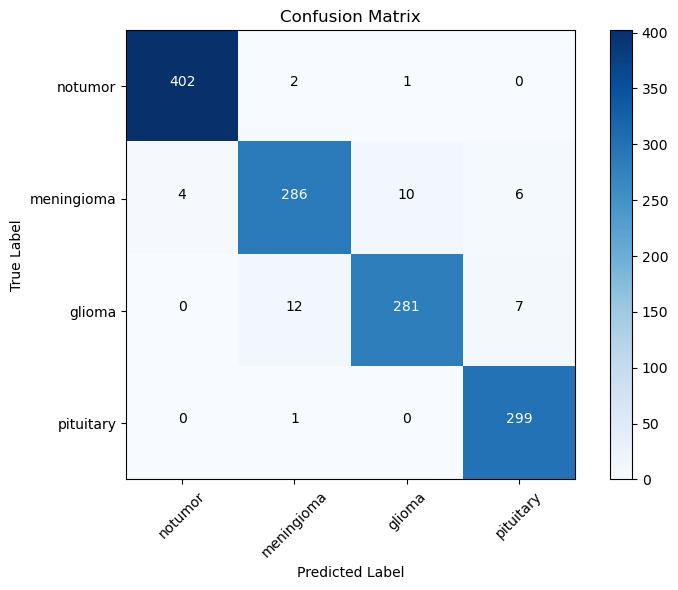

In [90]:
cm = confusion_matrix(y_true, y_pred)
labels = BrainTumorDataset.CLASSES

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

ticks = range(len(labels))
plt.xticks(ticks, labels, rotation=45)
plt.yticks(ticks, labels)

threshold = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()